# Analysis of the SSVEP data

Let's load a couple libraries we'll use repeatedly, and set the default plot size.

In [1]:
library(dplyr, warn.conflicts=FALSE)
library(stringr)
library(ggplot2)

options(repr.plot.width=10, repr.plot.height=4, repr.plot.res=300)

# Setup / preprocessing

The dataframe we're about to load has already undergone fourier transform & projection to FSAverage cortical space, so we're dealing with vertex numbers and frequency bin amplitudes, across subject and pre/post intervention measurement times.  This assumes it's in the same folder as the notebook; adjust path as needed:

**NOTE:** at the end of this section, we save out the munged data, so you can skip these cells on later runs.

## Load the cohort groupings

In [2]:
file.path("..", "..", "params") -> param_dir

# load intervention groups
file.path(param_dir, "intervention_cohorts.yaml") -> intervention_file
yaml::read_yaml(intervention_file) -> intervention

# load pre-test cohorts
file.path(param_dir, "letter_knowledge_cohorts.yaml") -> pretest_file
yaml::read_yaml(pretest_file) -> pretest

## Load and clean the brain data

In [3]:
proc.time() -> start
readr::read_csv("all_subjects-fsaverage-freq_domain-stc.csv") -> all_data
print(proc.time() - start)

Parsed with column specification:
cols(
  subject = col_character(),
  freq = col_double(),
  source = col_character(),
  value = col_double(),
  timepoint = col_character()
)



   user  system elapsed 
170.370   2.284 172.661 


Now to merge in the cohort groupings and do some light cleaning:

In [4]:
proc.time() -> start
all_data %>%
    tidyr::separate(source, c("hemi", "vertex"), sep="_") %>%
    rename(amplitude=value) %>%
    mutate(hemi=str_to_lower(hemi),
           vertex=as.integer(vertex),
           subj_num=str_sub(subject, -4),
           intervention=if_else(subj_num %in% intervention$LetterIntervention, "letter", "language"),
           pretest=if_else(subj_num %in% pretest$LowerKnowledge, "lower", "upper")) %>%
    # set column order
    select(subject, pretest, intervention, timepoint, freq, hemi, vertex, amplitude, -subj_num) ->
    all_data
print(proc.time() - start)

print(all_data)

   user  system elapsed 
206.166   9.088 215.263 
# A tibble: 247,774,464 x 8
   subject   pretest intervention timepoint  freq hemi  vertex amplitude
   <chr>     <chr>   <chr>        <chr>     <dbl> <chr>  <int>     <dbl>
 1 prek_1103 lower   language     pre           0 lh         0      21.9
 2 prek_1103 lower   language     pre           0 lh         1      57.1
 3 prek_1103 lower   language     pre           0 lh         2      50.4
 4 prek_1103 lower   language     pre           0 lh         3     125. 
 5 prek_1103 lower   language     pre           0 lh         4      69.9
 6 prek_1103 lower   language     pre           0 lh         5      13.2
 7 prek_1103 lower   language     pre           0 lh         6      29.3
 8 prek_1103 lower   language     pre           0 lh         7      46.5
 9 prek_1103 lower   language     pre           0 lh         8      78.1
10 prek_1103 lower   language     pre           0 lh         9      15.5
# … with 247,774,454 more rows


## Compute noise and SNR

Next we'll define a function that will compute noise (the mean of the two frequency bins below and two frequency bins above the current bin), and apply it within a `group_by` operation.

In [5]:
# function to compute noise (mean of 2 bins above and below; handles edges gracefully)
compute_noise <- function(x) {
    rowMeans(cbind(lag(x, 2), lag(x, 1), lead(x, 1), lead(x, 2)), na.rm=TRUE)
}

all_data %>%
    group_by(subject, timepoint, hemi, vertex) %>%
    mutate(noise=compute_noise(amplitude),
           snr=amplitude/noise) %>%
    ungroup() ->
    all_data

### Plot the frequency spectrum

Let's take a look at the average power spectrum across all vertices and subjects. The target frequencies are 2 Hz and 6 Hz, but we'll also highlight harmonics at 4, 12, and 18 Hz.

In [6]:
all_data %>%
    group_by(timepoint, freq) %>%
    summarise_at(c("amplitude", "snr"), mean) %>%
    mutate(target_freq=freq %in% c(2, 4, 6, 12, 18)) ->
    spectrum

print(spectrum)

# A tibble: 252 x 5
# Groups:   timepoint [2]
   timepoint  freq amplitude   snr target_freq
   <chr>     <dbl>     <dbl> <dbl> <lgl>      
 1 post        0       223.  0.748 FALSE      
 2 post        0.2     112.  1.57  FALSE      
 3 post        0.4     108.  1.38  FALSE      
 4 post        0.6      75.1 0.986 FALSE      
 5 post        0.8      62.3 0.990 FALSE      
 6 post        1        65.7 1.16  FALSE      
 7 post        1.2      54.9 1.02  FALSE      
 8 post        1.4      48.9 1.05  FALSE      
 9 post        1.6      44.8 1.01  FALSE      
10 post        1.8      39.1 0.994 FALSE      
# … with 242 more rows


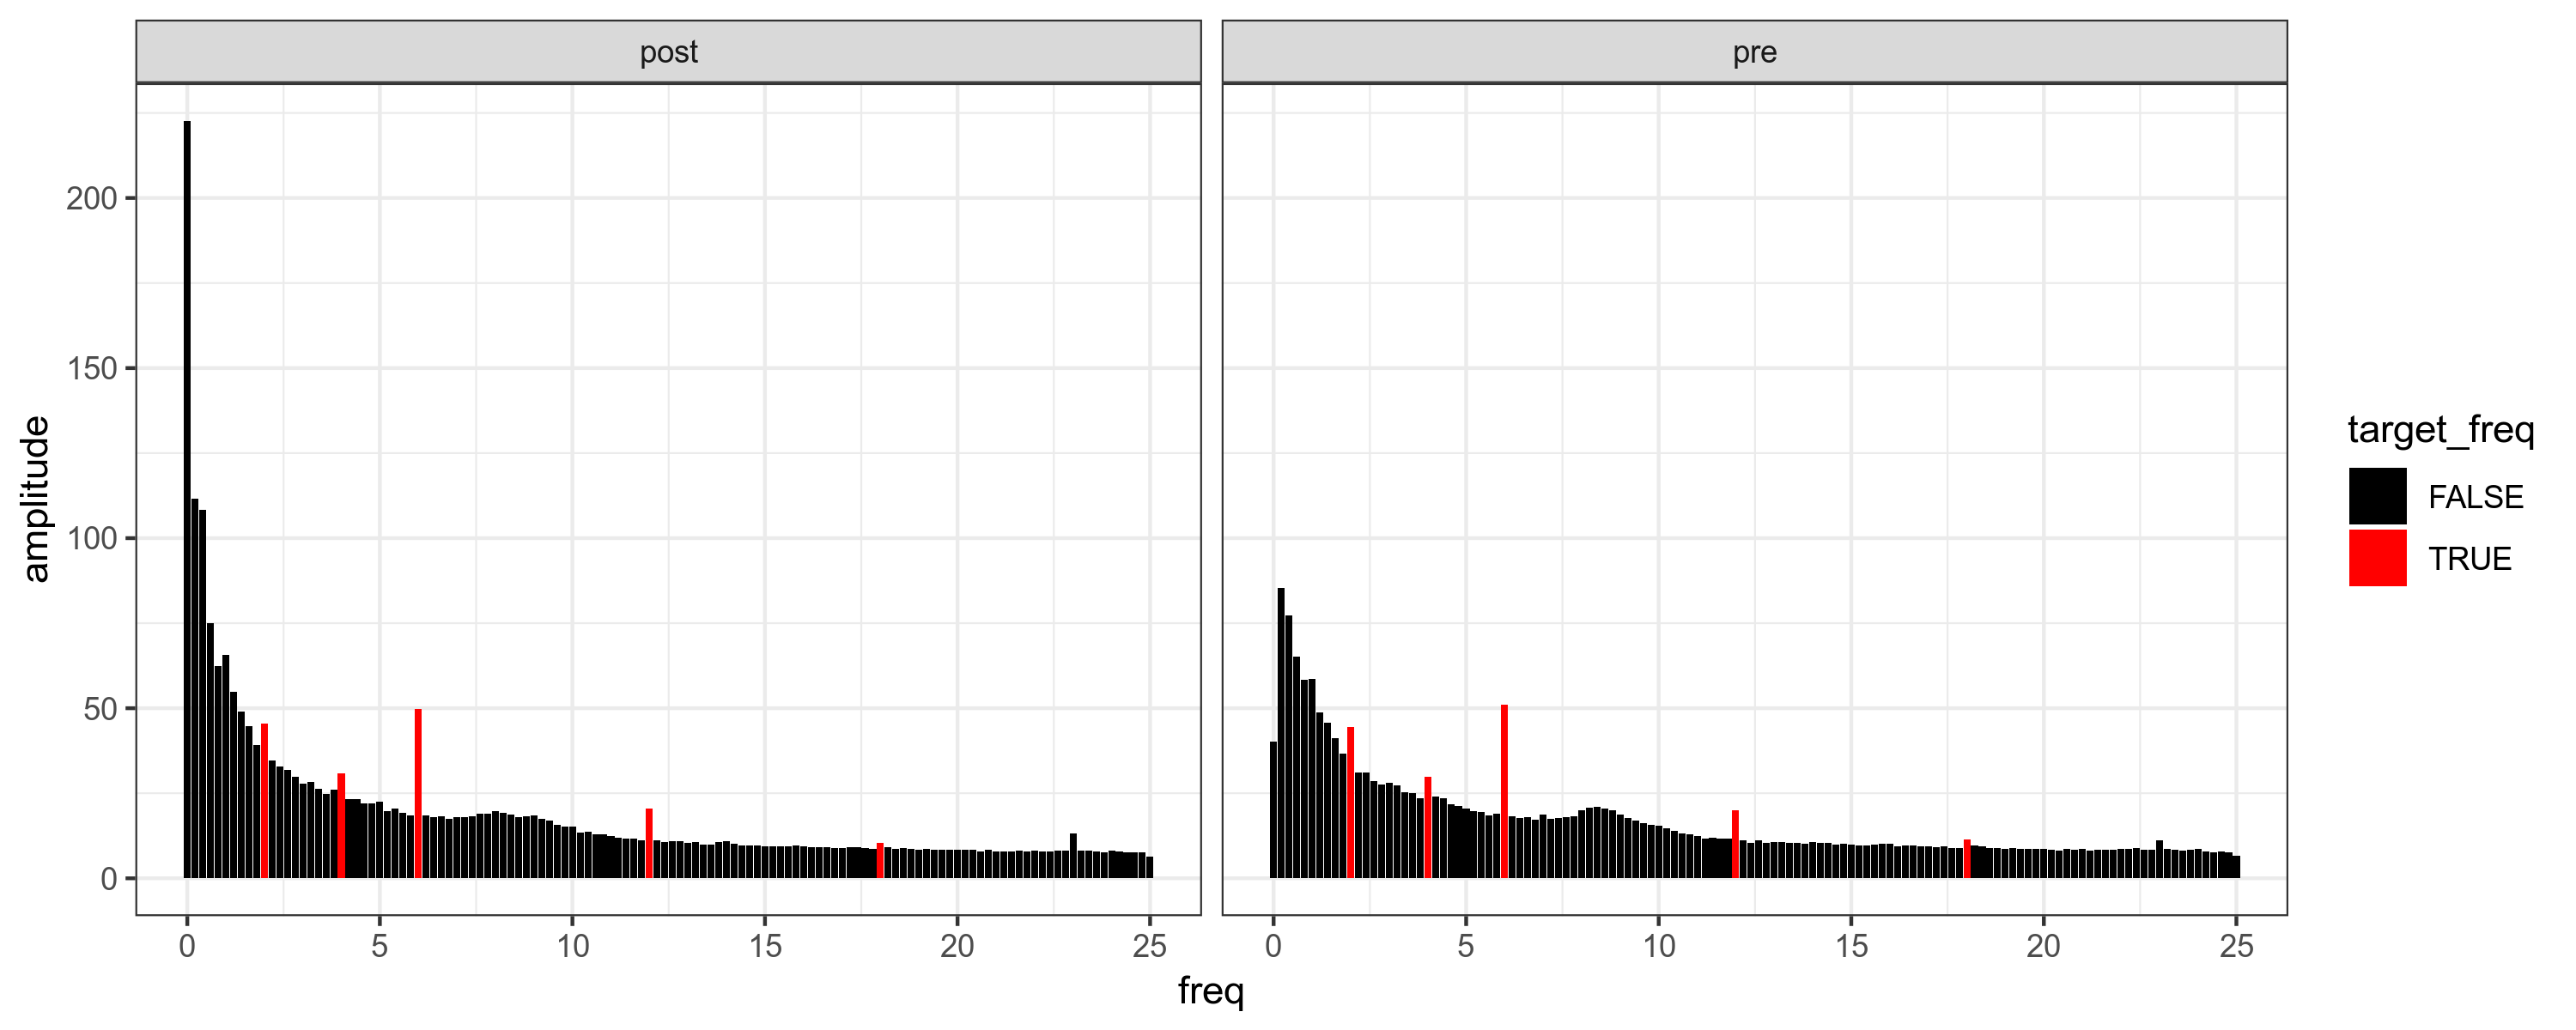

In [7]:
spectrum %>%
    ggplot(aes(x=freq, y=amplitude, fill=target_freq)) +
    facet_grid(. ~ timepoint) +
    geom_bar(stat="identity") +
    scale_fill_manual(values=c("black", "red")) +
    theme_bw()

OK, typical $\frac{1}{f}$ shape, with our target frequencies (and their harmonics) poking out. Let's flatten out the spectrum by looking at SNR instead of raw amplitude in each bin:

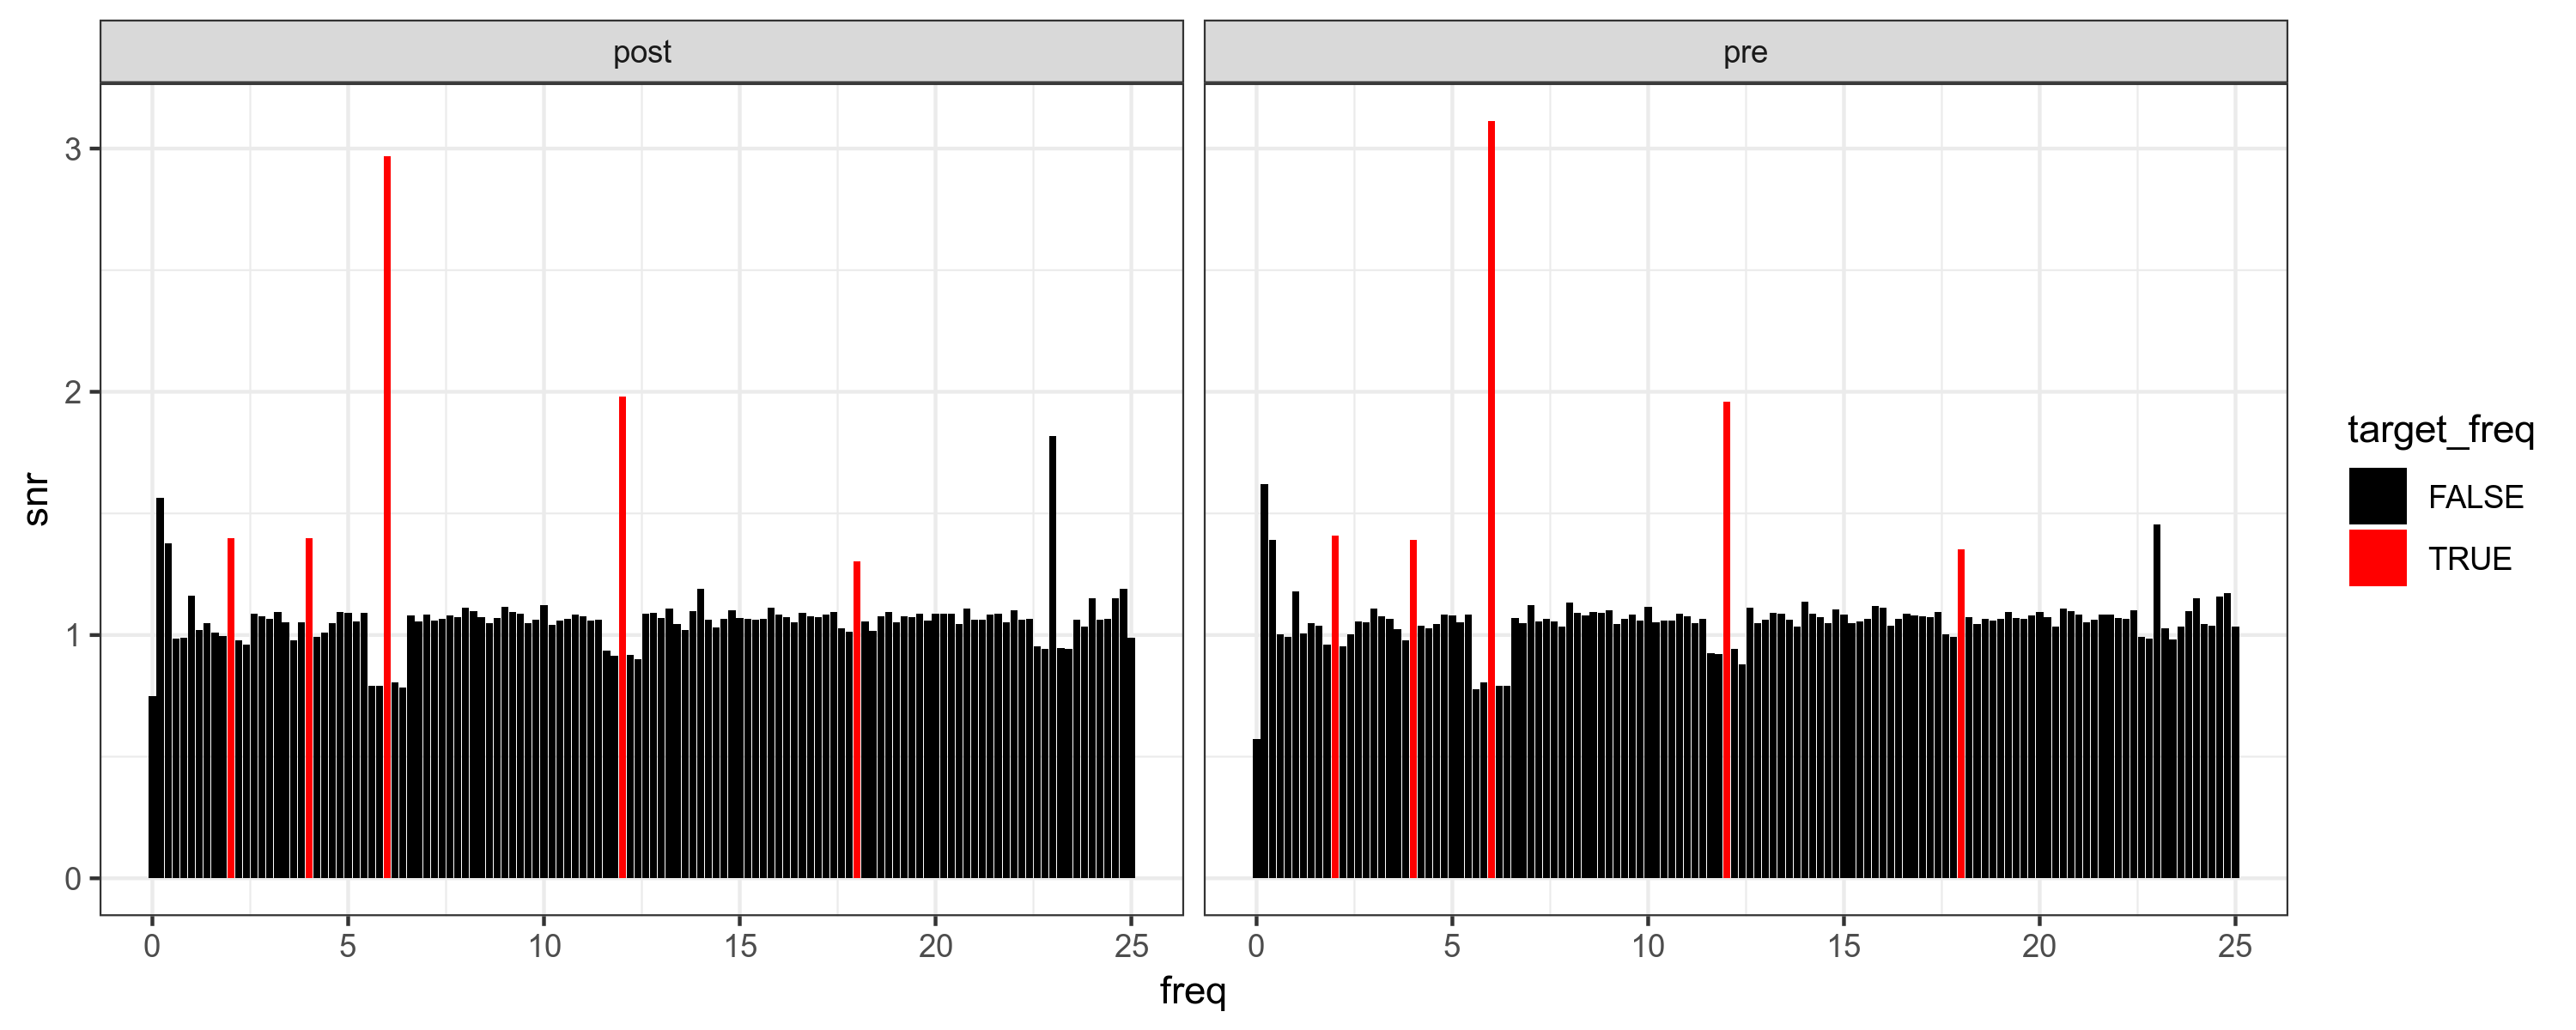

In [8]:
spectrum %>%
    ggplot(aes(x=freq, y=snr, fill=target_freq)) +
    facet_grid(. ~ timepoint) +
    geom_bar(stat="identity") +
    scale_fill_manual(values=c("black", "red")) +
    theme_bw()

That spike at 23 Hz (which is bigger in the post-intervention data) is a bit of a mystery.

## Make an ROI based on pre-intervention 2 Hz response
Next we'll compute an uncorrected t-statistic (across subjects, at each vertex) and use it as a mask to define an ROI. The 2 Hz response is what we care most about, so let's use it to filter on t-values greater than 4, and use that as our ROI for comparing the 2 Hz response in our cohorts.

### Compute t-statistic
First we compute an (uncorrected) t-test of "signal bin" vs "mean of adjacent noise bins". This will yield a new dataframe with the t-test results.

In [9]:
# compute signal-vs-noise uncorrected t-test
all_data %>%
    filter(freq == 2, timepoint == "pre") %>%
    group_by(hemi, vertex) %>%
    do(broom::tidy(t.test(.$amplitude, .$noise, paired=TRUE))) %>%
    rename(tval=statistic, df=parameter) ->
    tvals

### Merge
Now we merge the t-values back into the main dataframe, so we can use them to filter the data. Note that these t-values were computed *across subjects* as a way of defining an ROI, so joining based only on `hemi` and `vertex` is correct here.

In [10]:
# merge t-values back into main dataframe
all_data %>%
    left_join(tvals, by=c("hemi", "vertex")) ->
    all_data

### Reduce data

Now that we have the t-values, we'll filter the data to only include our ROI vertices and the frequency we care about, and average across vertices to get a mean activation within the ROI. We'll do separate ROIs for each hemisphere.

In [11]:
all_data %>%
    filter(tval >= 4, freq == 2) %>%
    group_by(subject, timepoint, intervention, pretest, hemi) %>%
    summarise_at(c("amplitude", "noise", "snr"), mean) %>%
    ungroup() ->
    roi_data

print(roi_data)

# A tibble: 192 x 8
   subject   timepoint intervention pretest hemi  amplitude noise   snr
   <chr>     <chr>     <chr>        <chr>   <chr>     <dbl> <dbl> <dbl>
 1 prek_1103 post      language     lower   lh         47.8  31.6  1.64
 2 prek_1103 post      language     lower   rh         61.2  36.1  1.82
 3 prek_1103 pre       language     lower   lh         49.4  31.5  1.62
 4 prek_1103 pre       language     lower   rh         65.0  23.7  2.90
 5 prek_1110 post      language     upper   lh         44.7  27.2  1.72
 6 prek_1110 post      language     upper   rh         27.6  25.4  1.19
 7 prek_1110 pre       language     upper   lh         53.1  25.7  2.30
 8 prek_1110 pre       language     upper   rh         42.8  28.6  1.60
 9 prek_1112 post      letter       lower   lh         85.0  68.6  1.24
10 prek_1112 post      letter       lower   rh         82.9  62.1  1.42
# … with 182 more rows


Now we save the preprocessing work, so we don't have to do it every time:

In [12]:
save(roi_data, file="processed_data_with_tvals.RData")
rm(all_data)  # free up memory

## Start here if skipping the preprocessing section

In [13]:
# load("processed_data_with_tvals.RData")

## Testing the main hypotheses

Now that we have our ROI data, let's test our hypotheses. We'll do it separately for each hemisphere.

### t-test of pre-intervention letter awareness

First we'll compare the two pretest groups (median split on the pre-intervention letter awareness test):

In [24]:
roi_data %>%
    filter(timepoint == "pre") %>%
    group_by(hemi) %>%
    do(broom::tidy(t.test(amplitude ~ pretest, data=.))) %>%
    rename(tval=statistic, df=parameter) ->
    pretest_tvals

pretest_tvals

hemi,estimate,estimate1,estimate2,tval,p.value,df,conf.low,conf.high,method,alternative
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
lh,-4.283796,53.83787,58.12167,-0.8652052,0.3916142,44.04624,-14.261969,5.694378,Welch Two Sample t-test,two.sided
rh,6.984452,60.41700,53.43255,1.0808198,0.2877170,32.56451,-6.169635,20.138538,Welch Two Sample t-test,two.sided


### t-test of intervention effect

For the intervention effect, what we care about is *change* in activation pre-versus-post intervention, so we'll need to do a `post - pre` subtraction first:

In [25]:
roi_data %>%
    tidyr::pivot_wider(names_from=timepoint, values_from=amplitude, id_cols=c(subject, intervention, hemi)) %>%
    mutate(post_minus_pre=post - pre) %>%
    group_by(hemi) %>%
    do(broom::tidy(t.test(post_minus_pre ~ intervention, data=.))) %>%
    rename(tval=statistic, df=parameter) ->
    intervention_tvals

intervention_tvals

hemi,estimate,estimate1,estimate2,tval,p.value,df,conf.low,conf.high,method,alternative
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
lh,-12.92581,-7.850338,5.075472,-2.115691,0.04009394,43.79586,-25.24032,-0.611302,Welch Two Sample t-test,two.sided
rh,-16.01271,-10.392635,5.620075,-2.296180,0.02630767,45.64730,-30.05283,-1.972593,Welch Two Sample t-test,two.sided


# Mixed model of intervention effect

Next let's see what the intervention effect looks like as a mixed model.

In [27]:
head(roi_data)

subject,timepoint,intervention,pretest,hemi,amplitude,noise,snr
<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>
prek_1103,post,language,lower,lh,47.79489,31.55692,1.640463
prek_1103,post,language,lower,rh,61.23694,36.12621,1.820090
prek_1103,pre,language,lower,lh,49.43963,31.54972,1.622696
prek_1103,pre,language,lower,rh,65.02063,23.65256,2.901838
prek_1110,post,language,upper,lh,44.65130,27.23542,1.719944
prek_1110,post,language,upper,rh,27.58946,25.39425,1.188579


In [32]:
# create factor variables and set contrasts
dev_contrast <- function(x, ...) {
    x <- factor(x, ...)
    contrasts(x) <- contr.sum
    contrasts(x) <- contrasts(x) / 2
    colnames(contrasts(x)) <- paste0("_", levels(x)[-length(levels(x))])
    x
}

roi_data %>%
    mutate(tpt=dev_contrast(timepoint, levels=c("pre", "post")),
           grp=dev_contrast(intervention, levels=c("language", "letter"))) %>%
    afex::mixed(snr ~ tpt * grp + (1|subject), data=., method="PB", REML=FALSE, check_contrasts=FALSE) ->
    model

summary(model)

Fitting 4 (g)lmer() models:
[....]
Obtaining 3 p-values:
[...]


Linear mixed model fit by maximum likelihood . t-tests use Satterthwaite's
  method [lmerModLmerTest]
Formula: snr ~ tpt * grp + (1 | subject)
   Data: data

     AIC      BIC   logLik deviance df.resid 
   284.2    303.8   -136.1    272.2      186 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-1.9126 -0.6568 -0.1671  0.5229  2.5092 

Random effects:
 Groups   Name        Variance Std.Dev.
 subject  (Intercept) 0.1472   0.3837  
 Residual             0.1654   0.4067  
Number of obs: 192, groups:  subject, 48

Fixed effects:
                      Estimate Std. Error        df t value Pr(>|t|)    
(Intercept)            1.90915    0.06267  48.00000  30.461  < 2e-16 ***
tpt_pre                0.12448    0.05870 144.00000   2.121  0.03567 *  
grp_language          -0.20716    0.12535  48.00000  -1.653  0.10492    
tpt_pre:grp_language   0.32638    0.11740 144.00000   2.780  0.00616 ** 
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation of Fixed 

# More detailed regressions

Here we explore the relationship between our ROI data and the various pre-test variables / dimensions.

### Load and clean behavioral metadata

First let's load the behavioral scores. We'll clean up a few columns and drop ones we don't need.

In [33]:
# load metadata
readr::read_csv(file.path("..", "behavioral", "preK_InterventionData.csv")) %>%
    # rename/transform variables
    rename(timepoint=visit) %>%
    mutate(subject=str_c("prek_", subID),
           intervention=str_to_lower(group)) %>%
    # reorder columns and drop unwanted columns
    select(subject, timepoint, intervention, everything(), -event, -subID, -group) ->
    metadata

print(metadata)

Parsed with column specification:
cols(
  subID = col_double(),
  event = col_character(),
  group = col_character(),
  AlphabetKnowledge = col_double(),
  Decoding = col_double(),
  PhonemeMatching = col_double(),
  PhonemeSegmenting = col_double(),
  EVTRaw = col_double(),
  Retell = col_double(),
  Grammar = col_double(),
  visit = col_character()
)



# A tibble: 96 x 10
   subject timepoint intervention AlphabetKnowled… Decoding PhonemeMatching
   <chr>   <chr>     <chr>                   <dbl>    <dbl>           <dbl>
 1 prek_1… pre       language                   49        0               7
 2 prek_1… post      language                   59        0               8
 3 prek_1… pre       language                   90        4              12
 4 prek_1… post      language                   93        0              12
 5 prek_1… pre       letter                     23        0              12
 6 prek_1… post      letter                     36        0              14
 7 prek_1… pre       language                   31        0               7
 8 prek_1… post      language                   34        0               8
 9 prek_1… pre       language                   82        0              15
10 prek_1… post      language                   89        5               8
# … with 86 more rows, and 4 more variables: PhonemeSegmenting <dbl>

### Merge brain data and metadata

Now we'll join our brain data and metadata.

In [34]:
roi_data %>%
    left_join(metadata, by=c("subject", "timepoint", "intervention")) ->
    roi_data

### Sample scatterplot

Let's take a look now at the relationship between the pre-test variables and the average 2 Hz response.

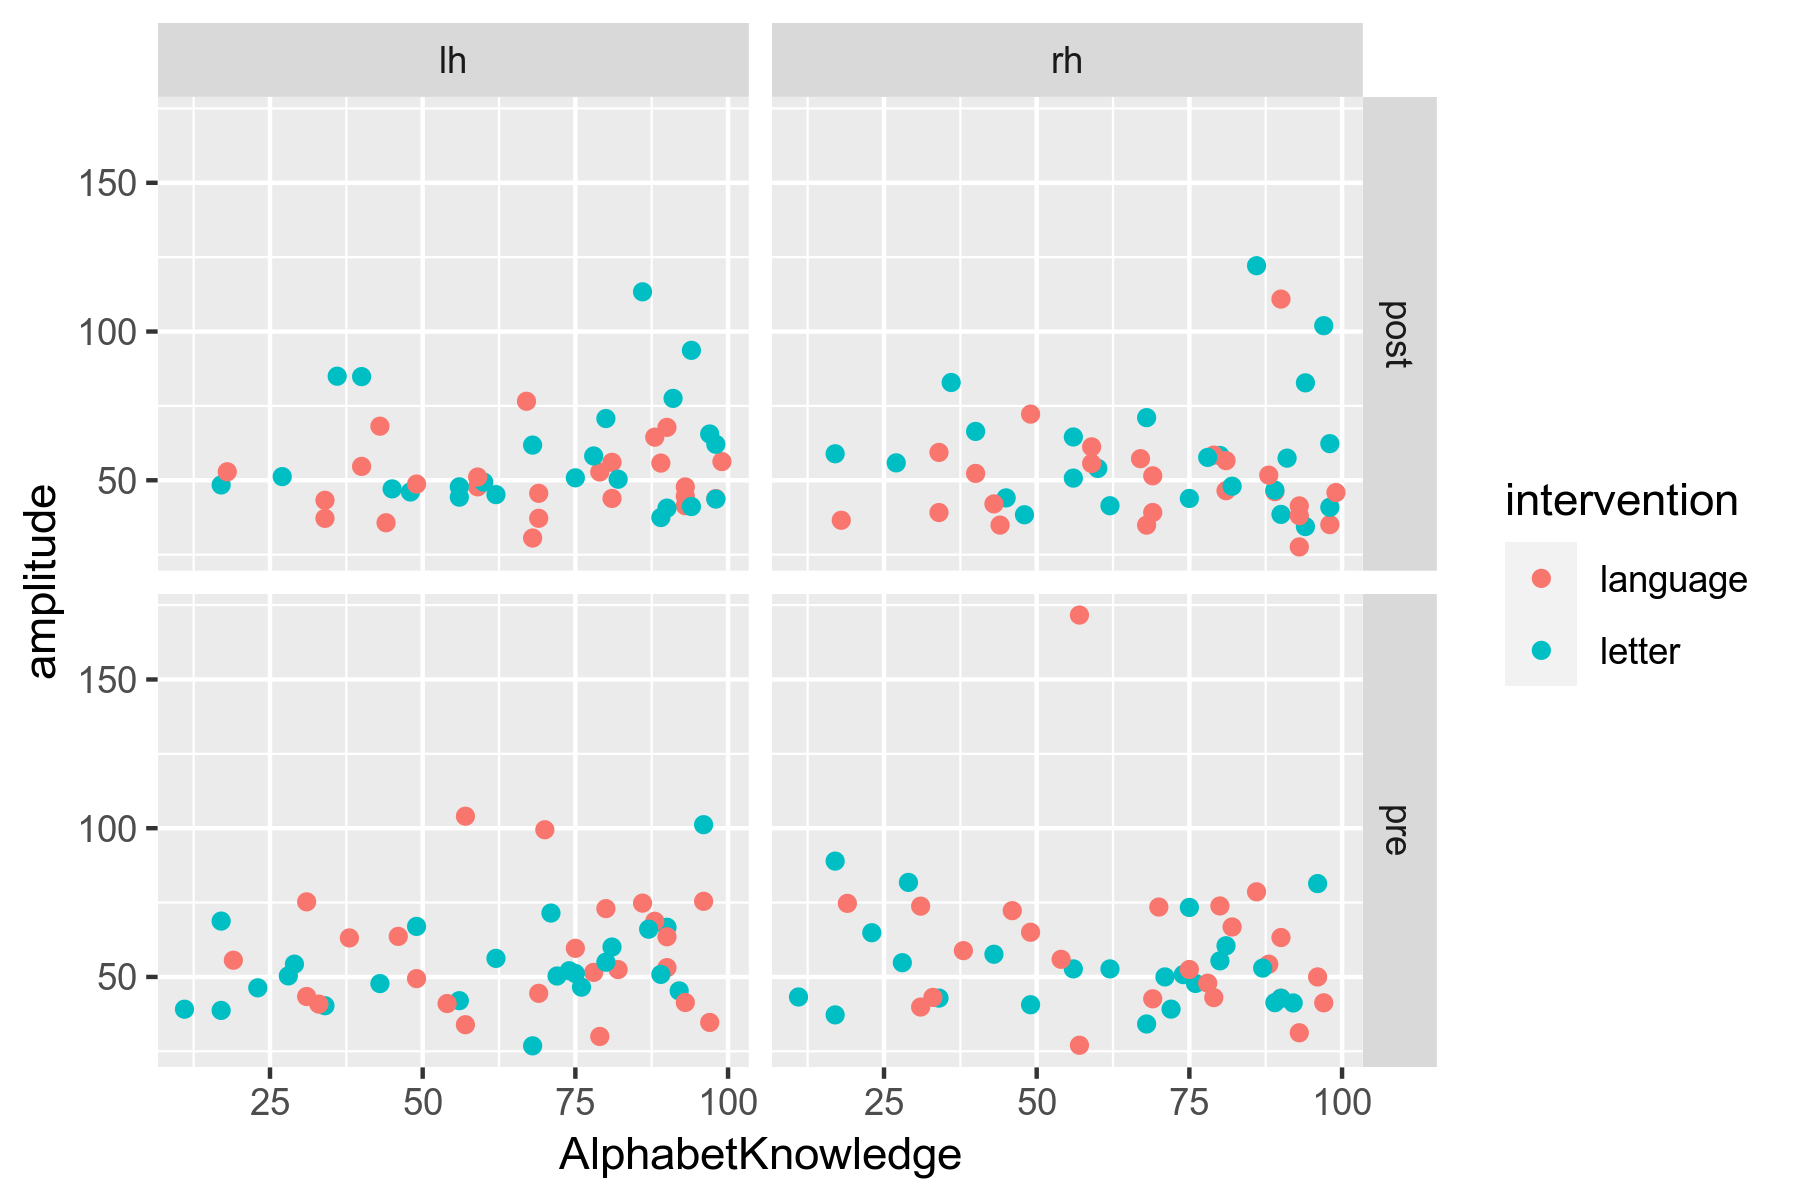

In [35]:
options(repr.plot.width=6)

roi_data %>%
    ggplot(aes(x=AlphabetKnowledge, y=amplitude, colour=intervention)) + 
    facet_grid(timepoint ~ hemi) + 
    geom_point()